# **Finding geese orientations**
_An infraslack nerd snipe | John Wiseman 2021-09-20_

On infraslack, jonty used a drone to take an overhead photo of some geese in a quarry.

<pre>
&lt;jonty&gt; geese geese geese
</pre>
![Geese](https://raw.githubusercontent.com/wiseman/geese-orientation/refs/heads/main/geese-original.jpg)
<pre>
&lt;Aaron Mathews&gt; look at all those chickens
&lt;wiseman&gt; I kinda want to see an orientation histogram for those ducks
&lt;jonty&gt; GEESE
&lt;jonty&gt; They honked 24/7
&lt;jonty&gt; @wiseman please calculate this histogram
</pre>

If you zoom in you can see enough detail to determine the geese orientations:

![Geese cropped](https://raw.githubusercontent.com/wiseman/geese-orientation/refs/heads/main/geese-original-cropped.png)

So now we just need code to automate it.

Originally I tried using Hough transforms but that didn't pan out. I ended up
using an approach inspired by the post [How to Determine the Orientation of an Object Using OpenCV](https://automaticaddison.com/how-to-determine-the-orientation-of-an-object-using-opencv/) by Addison Sears-Collins.


## Step 1: Manually mask out the non-water bits

I used [Affinity Photo](https://affinity.serif.com/en-us/photo/) and the selection brush tool.

![](https://i.imgur.com/HsaMn8S.jpeg)

## Step 2: Imports

In [1]:
import math

import cv2 as cv2
import matplotlib.pylab as plt
import numpy as np
from skimage import io

## Step 3: Read image from url

I saved the masked image above to github so it could be accessed from this notebook.


In [2]:
url = "https://raw.githubusercontent.com/wiseman/geese-orientation/main/geese-original.jpg"
geese_image = io.imread(url)
geese_image = cv2.cvtColor(geese_image, cv2.COLOR_BGR2RGB)
masked_url = (
    "https://raw.githubusercontent.com/wiseman/geese-orientation/main/geese-masked.jpg"
)
masked_geese_image = io.imread(masked_url)
masked_geese_image = cv2.cvtColor(masked_geese_image, cv2.COLOR_BGR2RGB)

## Step 4: Upscale the image

Each goose is represented by not all that many pixels in the original image, and this helps our processing be more accurate (thanks, Mark).

In [3]:
SCALING_FACTOR = 10

h, w = masked_geese_image.shape[:2]
print(f"Original resolution: {w}x{h}")
h = h * SCALING_FACTOR
w = w * SCALING_FACTOR
upscaled_masked_geese_image = cv2.resize(
    masked_geese_image, [w, h], interpolation=cv2.INTER_CUBIC
)
print(f"New resolution: {w}x{h}")

Original resolution: 4000x2250
New resolution: 40000x22500


## Step 5: Threshold the image

We convert the image to grayscale, and then threshold it so it's just black and white pixels.

In [4]:
_, thresholded_image = cv2.threshold(
    cv2.cvtColor(upscaled_masked_geese_image, cv2.COLOR_BGR2GRAY),
    100,
    255,
    cv2.THRESH_BINARY_INV,
)

Here's a cropped portion of the upscaled image:

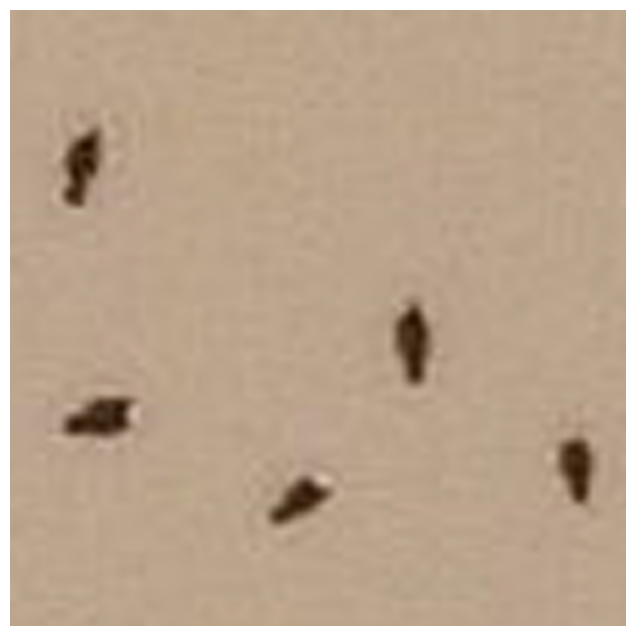

In [5]:
def show_crop(image, x, y, width, height):
    x_end, y_end = x + width, y + height
    h, w = image.shape[:2]
    x_end = min(max(0, x_end), w)
    y_end = min(max(0, y_end), h)
    cropped_image = image[y:y_end, x:x_end]
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


def show_image(image):
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


show_crop(upscaled_masked_geese_image, 21620, 13600, 1000, 1000)

And here's the thresholded version:

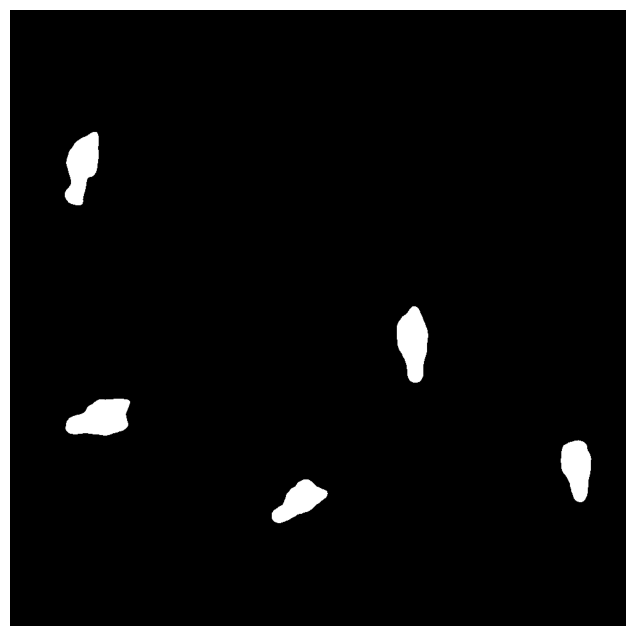

In [6]:
show_crop(thresholded_image, 21620, 13600, 1000, 1000)

## Step 6: Find contours

OpenCV's [`findContours`](https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html) function will find the outlines of the white geese blobs.


In [7]:
contours, _ = cv2.findContours(thresholded_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

## Step 7: Filter contours

We filter out any contours that are too big or too small.

In [8]:
print(f"Before filtering, found {len(contours)} contours")
contour_areas = [cv2.contourArea(c) for c in contours]
contours = [c for c, a in zip(contours, contour_areas) if a > 1000 and a < 10000]
print(f"After filtering we have {len(contours)} contours")

Before filtering, found 634 contours
After filtering we have 454 contours


So we found 454 goose-like objects.

## Step 8: Find the orientations

We use OpenCV's [`minAreaRect`](https://theailearner.com/tag/cv2-minarearect/) function to find the smallest oriented rectangle that contains each goose (contour). This is different from the usual bounding box because those are typically aligned to the image axes but the min area rect is rotated so it can be as small as possible.

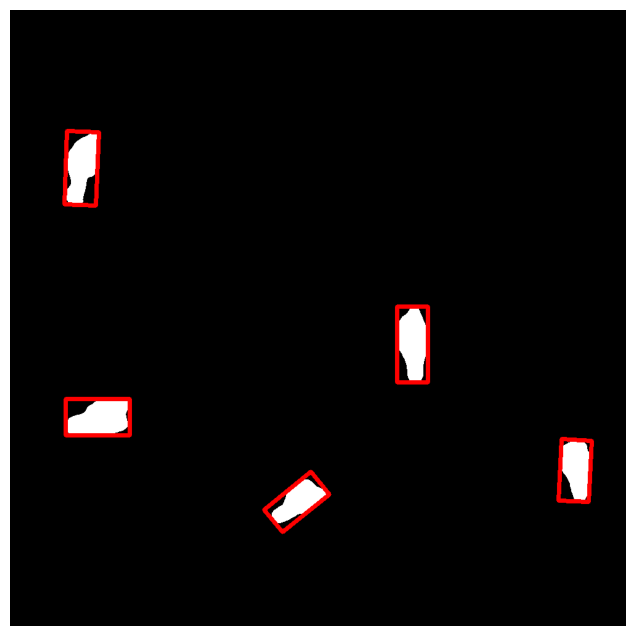

In [9]:
# Make a color copy of the image so we can draw on it using colors.
display_image = cv2.cvtColor(thresholded_image, cv2.COLOR_GRAY2BGR)
for c in contours:
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = box.astype(int)
    center = (int(rect[0][0]), int(rect[0][1]))
    width = int(rect[1][0])
    height = int(rect[1][1])
    cv2.drawContours(display_image, [box], -1, (0, 0, 255), 5)

show_crop(display_image, 21620, 13600, 1000, 1000)

## Step 9: Convert orientations to headings

For each rectangle we find the longest side, and determine the angle of that side.

We're not even going to try to worry about the 180 degree aliasing; that is, we're going to ignore the issue of figuring out which end of the goose is its head and which is its butt.

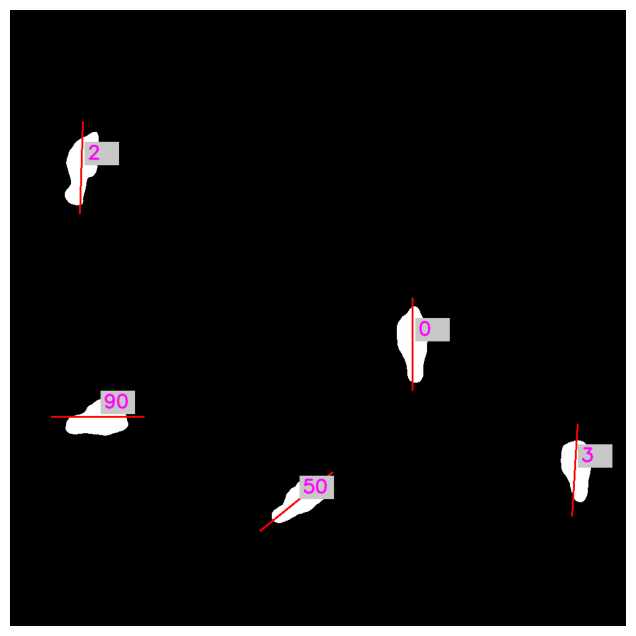

In [10]:
def normalize_heading(hdg):
    while hdg > 180:
        hdg -= 360
    while hdg < -180:
        hdg += 360
    return hdg


# Convert angle to heading.
def angle2heading(angle):
    return normalize_heading(90 - angle)


def rect_angle(vertices):
    vertices = np.array(vertices)
    if vertices.shape != (4, 2):
        raise ValueError("Expected 4 vertices with 2 coordinates each")
    # Calculate distances between consecutive vertices
    distances = []
    for i in range(4):
        p1 = vertices[i]
        p2 = vertices[(i + 1) % 4]
        dist = np.linalg.norm(p2 - p1)
        distances.append((dist, i))
    # Find the longest side
    longest_dist, longest_idx = max(distances)
    # Get the two points defining the longest side
    p1 = vertices[longest_idx]
    p2 = vertices[(longest_idx + 1) % 4]
    # Calculate angle
    delta_x = p2[0] - p1[0]
    delta_y = p2[1] - p1[1]
    # Special case for vertical lines to avoid floating point errors
    if abs(delta_x) < 1e-10:  # Use small epsilon instead of exact zero
        return 90.0
    # Calculate angle and normalize to [0, 180)
    # Note that we use -delta_y because in the image Y=0 is at the top
    # and increases as you go down, so we need to correct for that.
    angle_rad = math.atan2(-delta_y, delta_x)
    angle_deg = math.degrees(angle_rad)
    # Normalize to [0, 180)
    angle_deg = angle_deg % 180
    return angle_deg


headings = []

# Again, make a color copy of the image so we can draw on it using colors.
display_image = cv2.cvtColor(thresholded_image, cv2.COLOR_GRAY2BGR)
for c in contours:
    rect = cv2.minAreaRect(c)
    width = int(rect[1][0])
    height = int(rect[1][1])
    angle = rect_angle(cv2.boxPoints(rect))
    heading = angle2heading(angle)
    # Save the heading.
    headings.append(heading)
    # The rest of this is visualization, to draw lines and headings
    # on the image.
    center = (int(rect[0][0]), int(rect[0][1]))
    # Draw the heading line
    a = np.cos(np.radians(angle))
    b = np.sin(np.radians(angle))
    line_length = 150
    x = center[0]
    y = center[1]
    pt1 = (int(x + line_length / 2 * a), int(y - line_length / 2 * b))
    pt2 = (int(x - line_length / 2 * a), int(y + line_length / 2 * b))
    cv2.line(display_image, pt1, pt2, (0, 0, 255), 2)
    # Label the goose with its heading.
    cv2.rectangle(display_image, (x + 5, y - 42), (x + 60, y - 5), (200, 200, 200), -1)
    label = f"{int(heading)}"
    cv2.putText(
        display_image,
        label,
        (x + 10, y - 15),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.0,
        (255, 0, 255),
        2,
        cv2.LINE_AA,
    )

show_crop(display_image, 21620, 13600, 1000, 1000)

We plot the headings on the original image:

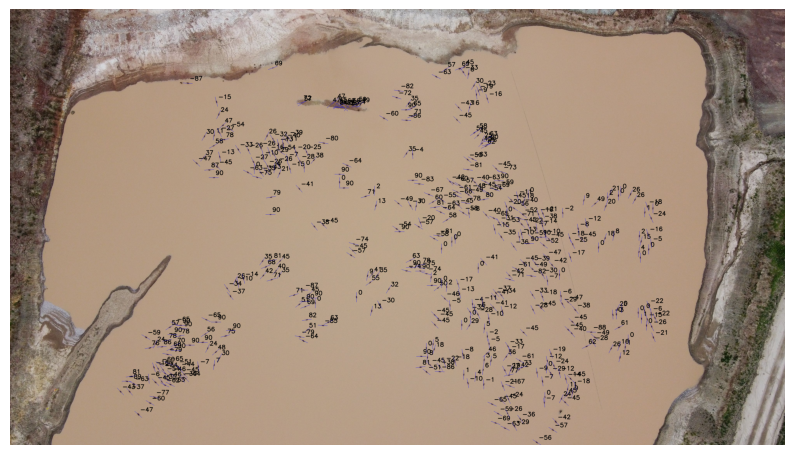

In [11]:
# Show the headings on the original image.
display_image = geese_image.copy()
for c in contours:
    rect = cv2.minAreaRect(c)
    width = int(rect[1][0])
    height = int(rect[1][1])
    box = cv2.boxPoints(rect)
    box = box.astype(int)
    angle = rect_angle(box)
    heading = angle2heading(angle)
    center = (int(rect[0][0]), int(rect[0][1]))
    # Draw the heading line
    a = np.cos(np.radians(angle))
    b = np.sin(np.radians(angle))
    line_length = 50
    x = int(center[0] / float(SCALING_FACTOR))
    y = int(center[1] / float(SCALING_FACTOR))
    pt1 = (int(x + line_length / 2 * a), int(y - line_length / 2 * b))
    pt2 = (int(x - line_length / 2 * a), int(y + line_length / 2 * b))
    cv2.line(display_image, pt1, pt2, (255, 0, 0), 1)
    # Label the goose with its heading.
    label = f"{int(heading)}"
    cv2.putText(
        display_image,
        label,
        (x + 10, y - 15),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.0,
        (0, 0, 0),
        2,
        cv2.LINE_AA,
    )
    box = (box / float(SCALING_FACTOR)).astype(int)
    # Uncomment this to see the little red boxes.
    # cv2.drawContours(display_image, [box], -1, (0, 0, 255), 1)

show_image(display_image)

## Step 10: Histograms

First create a histogram of observed headings:

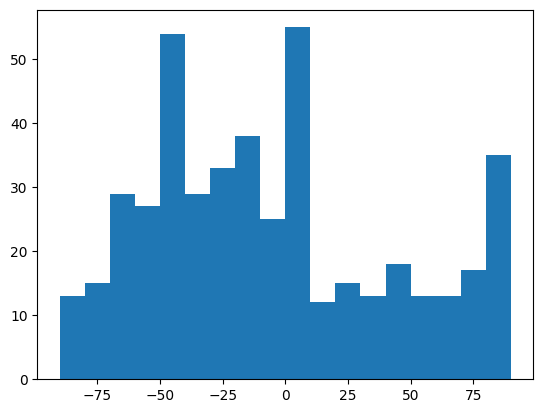

In [12]:
plt.hist(headings, bins=18, range=(-90, 90))
plt.show()

That's pretty ugly, so we're going to plot the histogram in a cool way like Geoff Boeing did for city streets in [Comparing US City Street Orientations](https://geoffboeing.com/2018/07/comparing-city-street-orientations/):

![](https://i1.wp.com/geoffboeing.com/wp-content/uploads/2018/07/city-street-orientations-usa-osmnx.png?resize=768%2C846&ssl=1)

The following code is adapted from Geoff Boeing's code for generating these histograms.


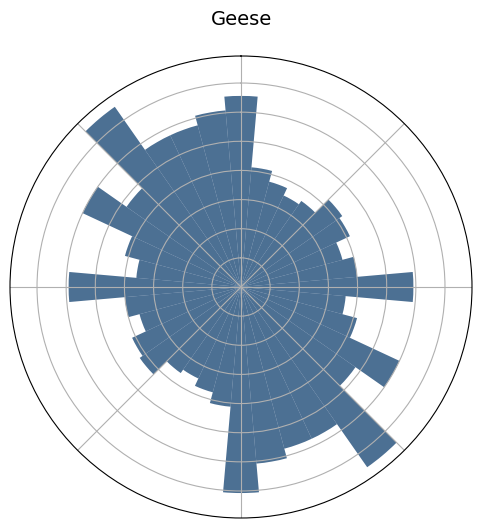

(<Figure size 600x600 with 1 Axes>, <PolarAxes: title={'center': 'Geese'}>)

In [13]:
def convert_headings_to_bearings(headings):
    """
    Convert headings from -90 to 90 degrees into bearings from 0 to 360 degrees.

    Parameters:
    - headings: array-like, list of headings from -90 to 90 degrees

    Returns:
    - bearings: array-like, list of bearings from 0 to 360 degrees
    """
    # Convert negative headings to positive bearings
    headings = [h for h in headings] + [h + 180 for h in headings]
    headings = np.array(headings)
    bearings = np.where(headings >= 0, headings, 360 + headings)
    return bearings


def plot_bearing_histogram(
    bearings,
    num_bins=36,
    area=True,
    color="#003366",
    edgecolor="k",
    alpha=0.7,
    title=None,
    title_y=1.05,
    figsize=(6, 6),
):
    """
    Plot a polar histogram of bearings.

    Parameters:
    - bearings: array-like, list of bearings from 0 to 360 degrees
    - num_bins: int, number of bins in the histogram
    - area: bool, if True, bar area is proportional to frequency
    - color: str, color of the bars
    - edgecolor: str, color of the bar edges
    - linewidth: float, width of the bar edges
    - alpha: float, opacity of the bars
    - title: str, title of the plot
    - title_y: float, y position of the title
    - figsize: tuple, size of the figure

    Returns:
    - fig, ax: Matplotlib figure and axis objects
    """
    # Convert bearings to radians
    bearings_rad = np.deg2rad(bearings)

    # Compute histogram
    bin_edges = np.linspace(0, 2 * np.pi, num_bins + 1)
    # Subtract 5 degrees from each bin_edge.
    bin_edges = bin_edges - (5.0 / 180.0) * np.pi
    counts, _ = np.histogram(bearings_rad, bins=bin_edges)

    # Adjust counts if area is proportional to frequency
    if area:
        counts = np.sqrt(counts)

    # Prepare the plot
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(polar=True))
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)  # Clockwise

    # Compute width and positions of each bin
    width = (2 * np.pi) / num_bins
    bin_centers = bin_edges[:-1] + width / 2

    # Plot the bars
    ax.bar(
        bin_centers,
        counts,
        width=width,
        bottom=0.0,
        color=color,
        edgecolor=edgecolor,
        linewidth=0,
        alpha=alpha,
        align="center",
    )

    # Set the title
    if title:
        ax.set_title(title, y=title_y, fontsize=14)

    # Set the labels for cardinal directions
    ax.set_xticks(np.deg2rad([0, 45, 90, 135, 180, 225, 270, 315]))
    # ax.set_xticklabels(["N", "NE", "E", "SE", "S", "SW", "W", "NW"], fontsize=12)
    ax.set_xticklabels([], fontsize=12)

    # Hide radial labels (optional)
    ax.set_yticklabels([])

    plt.show()
    return fig, ax


# Convert your headings to bearings
bearings = convert_headings_to_bearings(headings)

# Plot the polar histogram
plot_bearing_histogram(
    bearings,
    num_bins=36,
    area=True,
    title="Geese",
)

There it is.
